# 12-770 Spring 2025: Retro Radiators Modeling

Barbara Castro-Schell, Adwoa Asare, and Ziyuan Ma
2025-04-22

We will follow a very similar procedure as was done for Homework #2. Use Jupyter Notebooks to edit the file.

## Import data from sensors and PurpleAir data

In [103]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Read the CSV files
df_sensor = pd.read_csv('rad_off_data.csv', index_col=0, parse_dates=True)
df_outdoor = pd.read_csv('outdoor_temps.csv', index_col=0, parse_dates=True)

# Ensure the index is datetime for both DataFrames and set timezone awareness
df_sensor.index = pd.to_datetime(df_sensor.index, errors='coerce').tz_localize(None)
df_outdoor.index = pd.to_datetime(df_outdoor.index, errors='coerce').tz_localize(None)

# Drop the 'temperature (outdoor)' column from df_sensor
df_sensor.drop(columns=['temperature (outdoor)'], inplace=True)

# Combine df_sensor and df_outdoor based on timestamp difference
df_sensor['outdoor_temp'] = np.nan  # Initialize the outdoor_temp column
df_sensor['duty_cycle'] = 0  # Initialize the duty_cycle column
df_sensor['dt'] = np.nan

# Iterate through df_sensor and find matching timestamps in df_outdoor
for sensor_idx, sensor_row in df_sensor.iterrows():
    # Find rows in df_outdoor where the timestamp difference is less than 5 minutes
    matching_outdoor = df_outdoor.loc[abs(df_outdoor.index - sensor_idx) < pd.Timedelta(minutes=5)]
    if not matching_outdoor.empty:
        # Take the first matching value (if multiple matches exist)
        df_sensor.at[sensor_idx, 'outdoor_temp'] = matching_outdoor.iloc[0]['temp C']

# Display the updated df_sensor
df_sensor.head()

,sensor_id,humidity_rad,temp_rad,humidity_room,temp_room,outdoor_temp,duty_cycle,dt
timestamp,,,,,,,,
2025-04-02 20:02:00,radiator,41.3,25.5,NaN,NaN,15.443889,0,NaN
2025-04-02 20:04:00,room,NaN,NaN,40.5,23.3,15.443889,0,NaN
2025-04-02 20:11:00,radiator,41.0,24.9,NaN,NaN,15.666667,0,NaN
2025-04-02 20:14:00,room,NaN,NaN,41.5,23.3,15.666667,0,NaN
2025-04-02 20:21:00,radiator,51.4,20.1,NaN,NaN,16.332778,0,NaN


In [104]:
# We can implement this function as Python code to calculate the next step Ti
def ti(inputs, R, C, COP, P):

    ta = inputs[:,0]  # ambient temp

    mu = inputs[:,1]  # duty cycle
    dt = inputs[:,2]   # timestep
    y = np.zeros(len(inputs))
    y[0] = inputs[0,0] # use first value from data

    for t in range(1,len(y)):
        y[t] = 1/(C/dt[t]+1/R) * (C/dt[t]*y[t-1] + 1/R*ta[t] + mu[t]*COP*P)
    return y

                     temp_room  duty_cycle     dt  outdoor_temp
timestamp                                                      
2025-04-02 20:14:00       23.3           0  600.0     15.666667
2025-04-02 20:24:00       23.0           0  600.0     16.332778
2025-04-02 20:34:00       22.8           0  600.0     16.555000
2025-04-02 20:44:00       22.7           0  600.0     16.777778
2025-04-02 20:54:00       22.7           0  600.0     17.333333
                     temp_rad
timestamp                    
2025-04-02 20:02:00      25.5
2025-04-02 20:11:00      24.9
2025-04-02 20:21:00      20.1
2025-04-02 20:31:00      20.0
2025-04-02 20:41:00      19.9


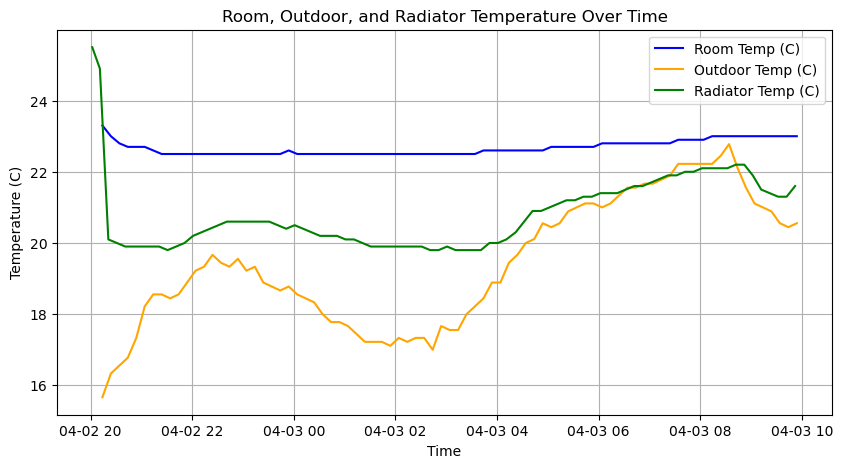

In [105]:
selectedCols = ['temp_room', 'duty_cycle', 'dt', 'outdoor_temp']  # Select the relevant columns
indoorTemp = 'temp_room'
radTemp = 'temp_rad'

# Drop rows with NaN values in the indoor temperature column
df1 = df_sensor[selectedCols].dropna(subset=[indoorTemp])
df1['dt'] = df1.index.to_series().diff().dt.total_seconds()  # Calculate the time difference in seconds
df1 = df1.dropna()
print(df1.head(5))

# Drop NaN values from the radiator temperature column
df2 = df_sensor[['temp_rad']].dropna()

# Drop values in df2 that come after the end of df1 data
df2 = df2[df2.index <= df1.index.max()]

# Ensure df2 index is unique and sorted
df2 = df2[~df2.index.duplicated(keep='first')].sort_index()
print(df2.head(5))

# Plot the time vs room temp, outdoor temp, and radiator temp
plt.figure(figsize=(10, 5))
plt.plot(df1.index, df1[indoorTemp], label='Room Temp (C)', color='blue')
plt.plot(df1.index, df1['outdoor_temp'], label='Outdoor Temp (C)', color='orange')
plt.plot(df2.index, df2[radTemp], label='Radiator Temp (C)', color='green')

plt.xlabel('Time')
plt.ylabel('Temperature (C)')
plt.title('Room, Outdoor, and Radiator Temperature Over Time')
plt.legend()
plt.grid()
plt.show()

In [106]:


def loss(df1, R, C):
    return np.sum((df1[indoorTemp].values - ti(df1.to_numpy(), R, C, 0, 0))**2)

# Initial estimates for R and C
initial_estimates = [0.1, 500000]

# Use curve_fit to estimate R and C
params, covariance = curve_fit(
    lambda inputs, R, C: ti(inputs, R, C, 0, 0),
    df1.to_numpy(),
    df1[indoorTemp].values,
    p0=initial_estimates,
)

R_estimated, C_estimated = params

# Calculate the thermal time constant
tau_seconds = R_estimated * C_estimated
tau_hours = tau_seconds / 3600

KequalsInF = 1.8  # C to F conversion factor

# Print results
print(f"\nEstimated R: {R_estimated*KequalsInF:.6} °F/W or {R_estimated:.6} °C/W")
print(f"Estimated C: {C_estimated / KequalsInF:.10} J/°F or {C_estimated:.9} J/°C")
print(f"Thermal Time Constant: {tau_seconds:.7} seconds or {tau_hours:.4} hours")


Estimated R: 3.60185e-05 °F/W or 2.00103e-05 °C/W
Estimated C: -5.05760517 J/°F or -9.10368931 J/°C
Thermal Time Constant: -0.0001821671 seconds or -5.06e-08 hours




### Problem #1 (15%):

Consider a room with the following conditions:

-   Dimensions are 2.5m, 4m and 5m (height, width and length).
-   One side has dimensions 2.5 x 4m and is entirely glazed with
    interior surface temperature of 10°C.
-   The other surfaces are at 20°C.
-   The air is at 22°C dry-bulb temperature and 30% relative humidity.

Given those conditions, answer the following questions:

#### 1.1: What is the MRT? (5%)

Generate the answer in the Python cell below:

In [107]:
# Your answer goes here

# What is the mean radiant temperature (the average temperature of all the surfaces around)?
height = 2.5 #m
width = 4 #m
length = 5 #m
T_glazed = 10
T_else = 20

A_total = height*width*2 + height*length*2 + width*length*2     #total surface area
A_glazed = height*width

MRT = (A_glazed*T_glazed + (A_total-A_glazed)*T_else)/A_total
print(f"The mean radiant temperature for this scenario is {MRT:.3} degrees Celsius")

#solid angle wikipedia - book also mentions it - okayed by Ozan

The mean radiant temperature for this scenario is 18.8 degrees Celsius


#### 1.2: What is the operative temperature? (5%)

Generate the answer in the Python cell below:

In [108]:
# Your answer goes here

# Operative temperature is "the average of the mean radiant and ambient air temperatures, weighted by their respective heat transfer coefficients"
#Assume that h_convection and h_radiation are equal
h_r = 3.1 #[W/m2K] found in Table 3.2 (with help from Colin)
h_c = 3.1   #[W/m2K] found in Table 3.2 

AAT = 22    #degrees C      -   dry-bulb temp

op_temp = (MRT*h_r+AAT*h_c)/(h_r+h_c)
print(f"The operative temperature is {op_temp:.3}°C")

The operative temperature is 20.4°C


#### 1.3: Are these conditions within the comfort limits of ASHRAE? (5%)

> An operative temperature of 20.4°C is only within the comfort limits of ASHRAE when the humidity level is between approximateo 0.007 and 0.012. In this case, since the humidity at 30% corresponds to a humidity ratio below 0.007, 20.4°C is too cold to be in the acceptable comfort range as defined by ASHRAE. 

### Problem 2 (10%):

A person feels very comfortable in their house when wearing light
clothing if the thermostat is set at 22°C and the MRT = 22°C. During a
cold day, the MRT drops to 18°C.

#### 2.1: To what value must the indoor dry-bulb air temperature be raised to maintain the same level of comfort? (5%)

Generate the answer in the Python cell below:

In [109]:
# Your answer goes here
T_op = 22
MRT = 18
AAT = 2*T_op-MRT

print(f"The indoor dry-bulb air temperature must be raised to {AAT}°C to achieve a mean radiant temperature of {MRT}°C.")

The indoor dry-bulb air temperature must be raised to 26°C to achieve a mean radiant temperature of 18°C.


#### 2.2: If the person sits near a window and receives solar radiation, the thermostat can be lowered. What types of factors will influence the amount by which the thermostat can be lowered? (5%):

> The factors that will influence the amount by which the thermostat can be lowered include:
>-   The MRT
>-   The window orientation and the corresponding solar orientation
>-   Shading
>-   The types of clothing they are wearing/the warmth of those clothes
>-   Metabolic rate



## 2. Thermal Network Models (20%)

We continue with more problems that are related to concepts covered
during the first few weeks of the class. For these, you will need to
read Chapter 8 of Reddy and any other references related to thermal
network models.

### Problem 1 (10%)

What is the time constant of a building with total heat loss coefficient
$K_{tot} = 30 kW/K$ and effective heat capacity $C_{eff} = 2.4 GJ/K$?
Estimate how long it takes the indoor temperature to drop from 20°C to
15°C after the heating system is shut off when $T_0 = 0$°C.

In [110]:
# Your answer goes here
import numpy as np

T0 = 0
Ti = 20     #T(0)
Tf = 15     #T(t)

Ktot = 30 #kW/K
Ceff = 2.4 #GJ/K

RC = (Ceff*10**6/Ktot)/3600     #converted to hours

# solution is T(t) = T(0)*exp(-t/RC)
t = -RC*np.log(Tf/Ti)

print(f"The time constant of this building is {RC:.3} hours.")
print(f"The time that it takes the indoor temperature to drop from 20°C to 15°C is {t:.3} hours")

The time constant of this building is 22.2 hours.
The time that it takes the indoor temperature to drop from 20°C to 15°C is 6.39 hours


### Problem 2 (10%)

The air conditoiner of a building is to be switched off during a hot day
so as to reduce electricity demand during the on-peak period. The
building has a time constant of 15h, and the sum of internal loads
(i.e., equipment, lights and people) and the solar loads divided by $UA$
is 4°C. Assume $T_{i,b}$ (the internal air temperature at the beginning
of the float-up period) to be 18°C. Calculate the number of hours it
takes for the building to heat up by 4°C when:

-   1.  The temperature difference between outdoor air and indoor at the
        start of the ramp-up is 10°C
-   1.  The temperature difference between outdoor air and indoor at the
        start of the ramp-up is 20°C

Comment on your findings.

In [111]:
# Your code goes here
tempDiff1 = 10  #degrees C
tempDiff2 = 20  #degrees C
Tib = 18        #degrees C
RQ = 4          #degrees C
tempRamp = 4    #degrees C
RC = 15

# solution is T(t) = T(0)*exp(-t/RC)
To1 = Tib + tempDiff1   #outside temp
Ti1 = Tib - To1 - RQ
Tf1 = Tib + tempRamp - To1 - RQ
t1 = -RC*np.log(Tf1/Ti1)
print(f"For scenario 1:\nThe time that it takes the indoor temperature to increase from 18°C to 22°C is {t1:.3} hours")

To2 = Tib + tempDiff2
Ti2 = Tib - To2 - RQ
Tf2 = Tib + tempRamp - To2 - RQ
t2 = -RC*np.log(Tf2/Ti2)
print(f"\nFor scenario 2:\nThe time that it takes the indoor temperature to increase from 18°C to 22°C is {t2:.3} hours")

For scenario 1:
The time that it takes the indoor temperature to increase from 18°C to 22°C is 5.05 hours

For scenario 2:
The time that it takes the indoor temperature to increase from 18°C to 22°C is 2.73 hours


## 3. Building Controls (55% +5%)

Now we will slowly work our way into the building controls (which we did
not cover in any detail during class) by expanding on what the thermal
network models allows us to do. We will begin with the calibration of a
simple 1R1C thermal network using actual data from an experiment, and
then move on to the simulation of a slightly more complex thermal
network that we will attempt to control using simple controllers.

Data is collected from an ecobee smart thermostat. It has measurements
of temperature and motion from 8 rooms, 1 basement, and thermostat
(i.e., 10 locations in total).

All the data is contained in the file named “data.csv”. Take a second to
open the file with your preferred excel viewer to familiarize yourself
with the data. This dataset contains data sampled with 5 minute
intervals from Mario’s house located in Pittsburgh, PA.

Though there are many other variables that you can analyze (for fun), we
will focus on the following for this homework. **Variables**:

-   **Date**: timestamp for the sample
-   **Thermostat Temperature (F)**: Thermostat Temperature (F)
-   **Outdoor Temp (F)**: Outdoor Temperature (F)
-   **Heat Stage 1 (sec)**: Heating Runtime (i.e., how many seconds the
    heating system was ON during that sample (seconds))

### Problem 1 (5%)

Finish the code cell below to be able to - (1) load the CSV file
called - (2) compute dt (time difference) between each sample in
seconds, save it as a column named “dt” - (3) convert heating stage to a
duty cycle (i.e., unitless parameter showing the ratio of heating system
being on in a range of 0-1), and name this “Heating Duty Cycle”
*data.csv* into memory.

Hint: - Use the
[`pandas.read_csv`](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) -
Use dt when computing the duty cycle from runtime.

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Insert your answer here
df = pd.read_csv('data.csv',index_col=0, parse_dates=['Date'])

# Compute dt (time difference in seconds)
df['dt'] = df.index.diff().total_seconds()

#convert heating stage to a duty dydcle
df['Heating Duty Cycle'] = df['Heat Stage 1 (sec)']/df['dt']

# dt will result in 1 nan value since the first row does not have a previous timestamp. you can just ignore the first row. 
df = df.iloc[1:]  # Removes the first row where dt is NaN

df.to_csv('data1.csv', index=False)

selectedCols = ['Outdoor Temp (F)','Heating Duty Cycle','dt','Thermostat Temperature (F)', 'Current Temp (F)']
df.head(5)


FileNotFoundError: [Errno 2] No such file or directory: 'data.csv'

### Problem 2 Fit your own 1R1C network and use it! (35% +5%)

Your goal is to estimate the values of $R$ and $C$ that “best” fit the
data, where by “best” we mean the values of $R$ and $C$ that minimize an
empirical loss function over the data. For simplicity, you may assume
that the loss function $\ell$ is the squared error loss
(i.e. $\ell = \sum_{j=1}^{N} \left(T_{i,j} - \hat{T}_{i,j}(R,C)\right)^2$,
where $T_{i,j}$ is the indoor temperature at the $j$-th sample, and
$\hat{T}_{i,j}$ is the estimated function for indoor temperature using
the 1R1C network model).

The equation of this model is:
$$C\frac{\mathrm{d}T_i}{\mathrm{d}t} = \frac{1}{R}(T_a-T_i)+Q$$

For our application want to use a discrete model that calculates the
value of $T_i$ as a function of the inputs $(T_a,\mu)$ and the
parameters $(R,C)$:

$$\Big(\frac{C}{\mathrm{d}t}+\frac{1}{R}\Big)T_i^{t+1} = \frac{C}{\mathrm{d}t}T_i^{t}+\frac{1}{R}T_a^{t+1}+\mu^{t+1}COP*P$$

$Q$ here can be any type of heating input coming from HVAC, internal
heat gains, occupants, solar irradiation. However, we will only focus on
heat coming from the HVAC system and assume rest is negligible since
Mario’s house is not advanced enough to have measurements of such heat
sources. Normally we would want to have heat supply ($Q$) measurements
directly however that is hard to measure, and thus is not available in
our data. One thing we can do is to use the duty cycle ($\mu$)
multiplied with power ($P$) and a constant coefficient of performance
(COP) to get the heat supply. Keep in mind that these are simplifying
assumptions.

For the sake of simplicity, assume $COP = 2.5$ and $P=5000$ (Watts)

In [ ]:
# We can implement this function as Python code to calculate the next step Ti
def ti(inputs, R, C, COP, P):

    ta = inputs[:,0]  # ambient temp

    mu = inputs[:,1]  # duty cycle
    dt = inputs[:,2]   # timestep
    y = np.zeros(len(inputs))
    y[0] = inputs[3,0] # use first value from data

    for t in range(1,len(y)):
        y[t] = 1/(C/dt[t]+1/R) * (C/dt[t]*y[t-1] + 1/R*ta[t] + mu[t]*COP*P)
    return y

### Problem 2.1. (10%)

Using the data we just loaded into memory, the function we implemented
above, and a curve fitting toolbox such as
[`scipy.optimize.curve_fit`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html)
to estimate the parameters for **each** of the test runs. Report $R$ and
$C$, and the thermal time constant. Do not forget to check and report
your units. Units are everything. Curve_fit is going to ask you for
initial estimates of R and C, you can use 0.1, 500000, respectively.

Hint 1: write the equation above using pen and paper to understand the
difference between the inputs and the parameters. Remember, we are only
trying to find $R$ and $C$ that best fit our data.

In [ ]:
# Insert your code here
from scipy.optimize import curve_fit

# indoorTemp = 'Thermostat Temperature (F)'
indoorTemp = 'Current Temp (F)' #could use either

df1 = df[selectedCols].dropna()
# print(df1.isna().sum())  # Check for missing values

def loss(df1, R, C):
    return np.sum((df1[indoorTemp].values - ti(df1.to_numpy(), R, C))**2)

# Initial estimates for R and C
initial_estimates = [0.1, 500000]

# Use curve_fit to estimate R and C - with documentation and chatGPT help
params, covariance = curve_fit(lambda inputs, R, C: ti(inputs, R, C), df1.to_numpy(), df1[indoorTemp].values, p0=initial_estimates, method = 'lm')
# curve_fit allows you to use a method like least squares to find the best fit for your data

R_estimated, C_estimated = params

# Calculate the thermal time constant
tau_seconds = R_estimated * C_estimated
tau_hours = tau_seconds/3600

KequalsInF = 1.8   #C to F conversion factor


# print(f"Error loss with initial parameters: {loss(df1,initial_estimates[0],initial_estimates[1]):.10} °F squared")
print(f"Estimated R: {R_estimated:.6} °F/W or {R_estimated/KequalsInF:.6} °C/W")
print(f"Estimated C: {C_estimated:.10} J/°F or {C_estimated*KequalsInF:.9} °C/W")
print(f"Thermal Time Constant: {tau_seconds:.7} seconds or {tau_hours:.4} hours")
# print(f"Error loss for optimized parameters: {loss(df1,R_estimated,C_estimated):.7} °F squared")

print(df1)


NameError: name 'df' is not defined

### Bonus: Comment on your findings (+5%)

What is the comparison of the $R$, $C$ and time constant values you
found by answering Problem 2 and the values recommended by online
search? Do they make sense? Are they larger/smaller than what you would
expect? What could be some reasons that we got values smaller/larger
than expectations?

>   [Energy Star](https://www.energystar.gov/saveathome/seal_insulate/identify-problems-you-want-fix/diy-checks-inspections/insulation-r-values) recommends around R15 (15 ft2⋅°F⋅hr/BTU) insulative wall sheathing in climate region 5 such as Pittsburgh which translates to a value of 2.6 K/W for recommended thermal resistance. This [source](https://www.energystar.gov/ia/partners/bldrs_lenders_raters/downloads/RefStdsFinal_112006.pdf) from Energy Star also recommends a similar R-value for Energy Star qualification. The estimated thermal resistance value of 0.0102 °F/W is on the lower end of the typical range. This suggests that the building has very low thermal resistance, meaning it loses heat quickly.

> Thermal capacitance of residential buildings can vary from thousands to millions (in J/K) depending on the size and materials of the home. This makes it hard to determine an expected thermal capacitance for Mario's house with the given information since we don't have a good understanding of the size or the materials of the home. According to [IPBC2018](https://surface.syr.edu/cgi/viewcontent.cgi?article=1283&context=ibpc#:~:text=In%20winter%2C%20the%20majority%20of%20time%20constants,the%20age%20of%20the%20home%20is%20investigated.), "in winter, the majority of time constants range from 15 to 55 hours." Therefore, the RC value of 36.18 hours is in the middle of the expected range. This observation, combined with the lower than expected R value, indicates that the C value is relatively high for the house.  

> It is also worth noting that the Ti function given to us uses the third row of the ambient temperatures as the initial indoor temperature. This may contribute to errors in the analysis. When adjusting this function, the RC value changes. 

> Some reasons that we got smaller than expected values for R and C could include:
>    -   The thermostat is close to the door or in a particularly leaky region of the house and doesnt reflect the true value of the total thermal resistace of the house
>    -   Noisy data could cause issues with R and C estimation
>    -   Simplifying assumptions used such as constant power and COP could be indicating heat input values that are higher than those that are occurring in real-life



### Check how the model behaves (5%)

Well, let’s see if your extra-sophisticated, super-realistic 1R1C model
of Mario’s house works as expected. As an engineer, building scientist,
or HVAC enthusiast, you can analyze its behavior by conducting test
cases. Choose values for Ta, dt, and an initial temperature T, apply the
1R1C model structure, and adjust the mu value to observe how different
control inputs result in different output temperatures. Comment on your
findings.

Run 1:   Run 2:   Run 3:   Run 4:
25.0     25.0     25.0     25.0
28.4     28.4     28.4     28.4
31.8     31.8     31.8     31.8
35.0     35.0     35.0     35.0
38.2     38.2     38.2     38.2
41.3     41.3     41.3     41.3
44.2     44.2     44.2     44.2
47.2     47.2     47.2     47.2
50.0     50.0     50.0     50.0
52.8     52.8     52.8     52.8
55.4     55.4     55.4     55.4
58.0     58.0     58.0     58.0
60.6     60.6     60.6     60.6
63.1     63.1     63.1     63.1
65.5     65.5     65.5     65.5
67.8     67.8     67.8     67.8
70.1     70.1     70.1     70.1
72.3     72.3     72.3     72.3
74.5     74.5     74.5     74.5
76.6     76.6     76.6     76.6


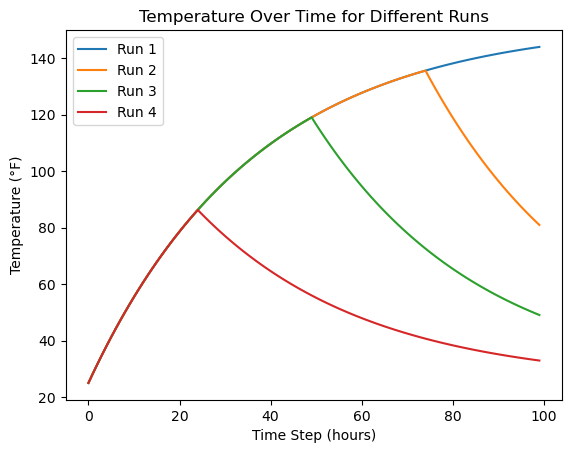

The indoor temperature at the time that HVAC is turned off impacts how the rate at which the temperature drops.
For the duration that the HVAC is on, The rate at which the temperature increases goes down as the indoor temperature gets larger than the ambient temperature.


In [ ]:
# Insert your code here
#you have the model structure from the ti function
# assume some values for state

# Choose values for Ta, dt, and an initial temperature T
steps = 100      #hours of simulation
T_init = 67     #F
temps = np.array([T_init]*steps)
# initial temp is set to value of ambient temperature becasue of the nature of Ti function

ta = np.array([25]*steps)     #F
mu1 = np.array([1]*steps)    #duty cycle
dt = np.array([3600]*steps)      #seconds
inputs = np.column_stack((ta, mu1, dt, temps))

#Apply the 1R1C model structure
y1 = ti(inputs, R_estimated, C_estimated, COP, P)

# Adjust the mu value to observe how different control inputs result in different output temperatures
mu2 = np.concatenate((np.ones(int(np.ceil(0.75*steps))), np.zeros(int(np.floor(0.25*steps)))))   #duty cycle
inputs = np.column_stack((ta, mu2, dt, temps))
y2 = ti(inputs, R_estimated, C_estimated, COP, P)

mu3 = np.concatenate((np.ones(int(np.ceil(0.5*steps))), np.zeros(int(np.floor(0.5*steps)))))   #duty cycle
inputs = np.column_stack((ta, mu3, dt, temps))
y3 = ti(inputs, R_estimated, C_estimated, COP, P)

mu4 = np.concatenate((np.ones(int(np.ceil(0.25*steps))), np.zeros(int(np.floor(0.75*steps)))))
inputs = np.column_stack((ta, mu4, dt, temps))
y4 = ti(inputs, R_estimated, C_estimated, COP, P)

print("Run 1:   Run 2:   Run 3:   Run 4:")
for i in range(20):
    print(f"{y1[i]:.3}     {y2[i]:.3}     {y3[i]:.3}     {y4[i]:.3}")

# Plot the results on the same chart
plt.plot(y1, label='Run 1')
plt.plot(y2, label='Run 2')
plt.plot(y3, label='Run 3')
plt.plot(y4, label='Run 4')
plt.xlabel('Time Step (hours)')
plt.ylabel('Temperature (°F)')
plt.title('Temperature Over Time for Different Runs')
plt.legend()
plt.show()

# Comment on your findings
print(f"The indoor temperature at the time that HVAC is turned off impacts how the rate at which the temperature drops.")
print(f"For the duration that the HVAC is on, The rate at which the temperature increases goes down as the indoor temperature gets larger than the ambient temperature.")

### Problem 2.2: Implement a Bang Bang Controller (10%)

Your task is to **implement a Bang-Bang controller** to regulate indoor
temperature using a simple on/off control strategy. The heating system
should:  
- **Turn ON** (`μ = 1`) when the indoor temperature falls **at or
below** the setpoint.  
- **Turn OFF** (`μ = 0`) when the temperature **exceeds** the setpoint
plus a hysteresis margin.

This prevents excessive switching and stabilizes operation.

**Implementation Details**  
Write a function
`bang_bang_controller(setpoint, hysteresis, x_init, ta, control_interval, num_steps)`
that:  
- Takes in `setpoint`, `hysteresis`, `x_init`, `ta` (ambient temp),
`control_interval`, and `num_steps` (how many steps you want to simulate
it).  
- Returns arrays of **control actions** (`μ`) and **indoor
temperatures** (`x`).

**Control Interval**  
The controller checks and updates the heating state **every
`control_interval` seconds** based on the current indoor temperature.

In [ ]:
import numpy as np

def bang_bang_controller(setpoint, hysteresis, x_init, ta, control_interval, num_steps, R, C, COP, P):

    dt = control_interval

    mu = np.zeros(num_steps)    #control actions
    x = np.zeros(num_steps)     #indoor temps
    
    # Set initial indoor temperature
    x[0] = x_init
    
    # Iterate over each time step
    currentMu = mu[0]
    for t in range(1, num_steps):
        # Check if the indoor temperature is at or below the setpoint
        if x[t-1] <= setpoint:
            currentMu =  1  # Turn on
        elif x[t-1] > setpoint + hysteresis:
            currentMu = 0  # Turn off

        mu[t] = currentMu
        
        # Calculate the next indoor temperature using the ti function
        x[t] = 1/(C/dt+1/R) * (C/dt*x[t-1] + 1/R*ta + mu[t]*COP*P)
    
    return mu, x

# Define parameters
setpoint = 72  # Desired indoor temperature in °F
hysteresis = 1  # To prevent frequent switching 
x_init = 72  # Initial indoor temperature
ta = 60  # Ambient temperature (constant)
control_interval= 30  # 30 second control interval
COP = 2.5  # Coefficient of performance
P = 5000  # Heating power in watts
R = R_estimated
C = C_estimated

total_time = 12 * 3600  # 12 hours in seconds
num_steps = total_time // control_interval  # Number of simulation steps

# call your function here
mu72, x72 = bang_bang_controller(setpoint, hysteresis, x_init, ta, control_interval, num_steps, R, C, COP, P)

for i in range(20):
    print(f"μ: {mu72[i]},     x: {x72[i]:.4} °F")

μ: 0.0,     x: 72.0 °F
μ: 1.0,     x: 72.03 °F
μ: 1.0,     x: 72.05 °F
μ: 1.0,     x: 72.08 °F
μ: 1.0,     x: 72.11 °F
μ: 1.0,     x: 72.13 °F
μ: 1.0,     x: 72.16 °F
μ: 1.0,     x: 72.19 °F
μ: 1.0,     x: 72.21 °F
μ: 1.0,     x: 72.24 °F
μ: 1.0,     x: 72.27 °F
μ: 1.0,     x: 72.29 °F
μ: 1.0,     x: 72.32 °F
μ: 1.0,     x: 72.35 °F
μ: 1.0,     x: 72.37 °F
μ: 1.0,     x: 72.4 °F
μ: 1.0,     x: 72.42 °F
μ: 1.0,     x: 72.45 °F
μ: 1.0,     x: 72.48 °F
μ: 1.0,     x: 72.5 °F


### Problem 2.3. How much energy would Mario save if he reduces his setpoint by 2F? (5%)

Here, you will use your simulator of a bang bang controller you
developed in the previous step. You will re-run the previous conditions
with only one difference (i.e, setpoint now will be 70F).

-   1.  Make a plot demonstrating the temperature trajectory for both
        runs (in a single plot). Comment on the trajectories.
-   1.  You will compute the total **energy** consumed in each run. You
        will report the consumed energy in each run (with their units),
        and the percent reduction when reduced the setpoint to 70F.

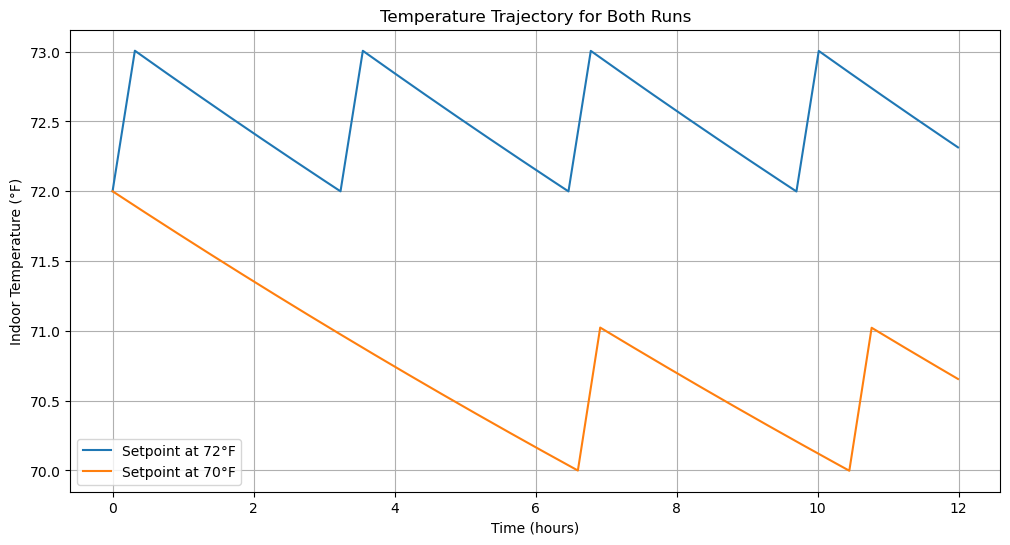

Total energy consumed for 72°F setpoint: 2.5333 kWh
Total energy consumed for 70°F setpoint: 1.2667 kWh

Mario would save 1.2667 for a reduction of 50.0% by reducing his setpoint 2°F


In [ ]:
# Insert your code here

# Define parameters for setpoint 70°F
setpoint70 = 70

# Call the bang_bang_controller function for setpoint 70°F
mu70, x70 = bang_bang_controller(setpoint70, hysteresis, x_init, ta, control_interval, num_steps, R, C, COP, P)

plt.figure(figsize=(12,6))
plt.plot(np.arange(num_steps) * control_interval / 3600, x72, label='Setpoint at 72°F')
plt.plot(np.arange(num_steps) * control_interval / 3600, x70, label='Setpoint at 70°F')
plt.xlabel('Time (hours)')
plt.ylabel('Indoor Temperature (°F)')
plt.title('Temperature Trajectory for Both Runs')
plt.legend()
plt.grid(True)
plt.show()

# Insert your code here
# Compute the total energy consumed in each run
energy_consumed_72 = np.sum(mu72) * control_interval * P / (COP*3600000)  # Energy in kWh
energy_consumed_70 = np.sum(mu70) * control_interval * P / (COP*3600000)  # Energy in kWh

# Calculate the percent reduction in energy consumption
percent_reduction = ((energy_consumed_72 - energy_consumed_70) / energy_consumed_72) * 100

print(f"Total energy consumed for 72°F setpoint: {energy_consumed_72:.4f} kWh")
print(f"Total energy consumed for 70°F setpoint: {energy_consumed_70:.4f} kWh")
print(f"\nMario would save {(energy_consumed_72 - energy_consumed_70):.4f} for a reduction of {percent_reduction:.1f}% by reducing his setpoint 2°F")



### Problem 2.4. Free floating behavior (5%)

Here, you will make a plot of the free floating behavior when $ta = 60$
and $x_{init} = 72$. You will turn your HVAC system off in your 1R1C
model and then store the temperature trajectory. Analyze the plot,
comment on the behavior, is it in-line with what your amazing intuition
would say?

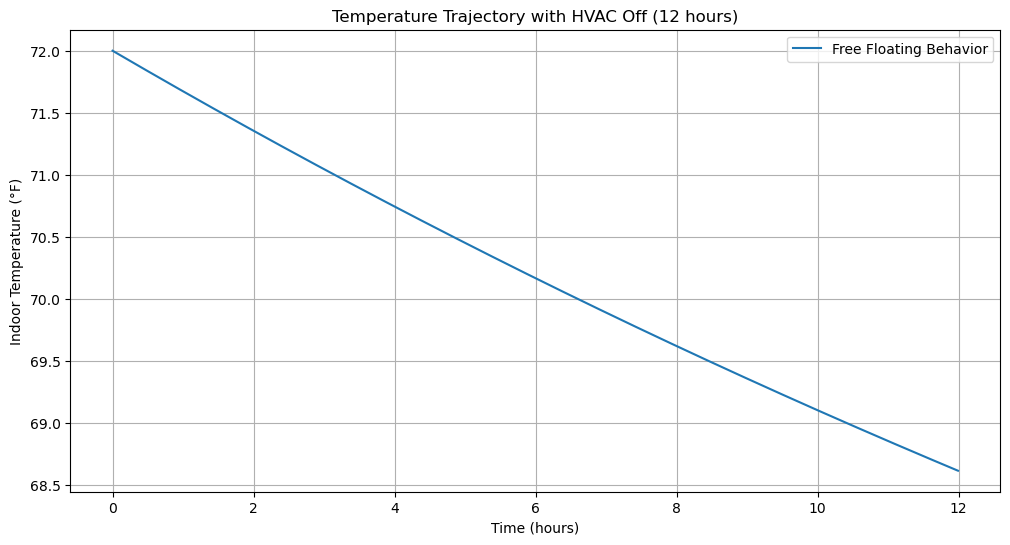

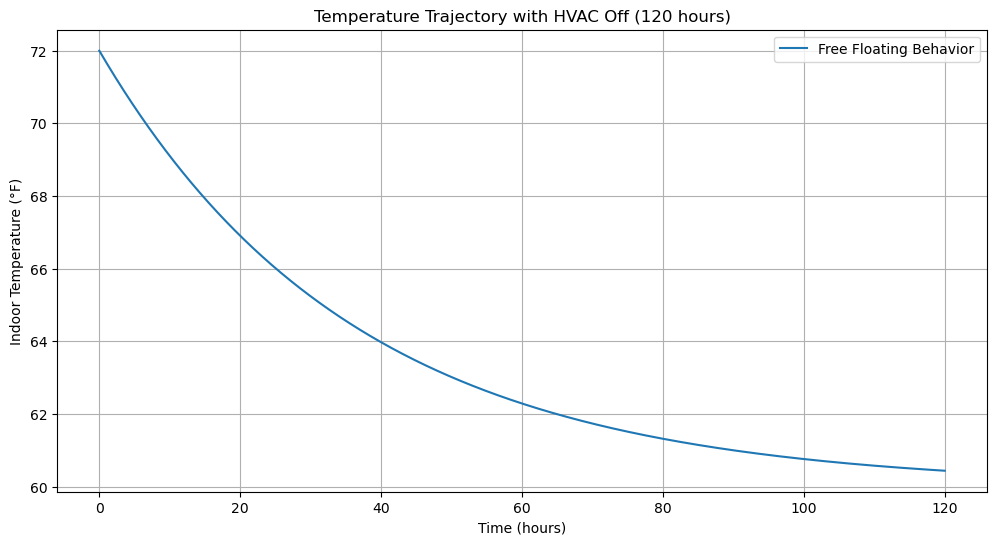

As an exponential decay graph, approaching the ambient temperature for the hours that the HVAC system 
is off, this is in line with what my amazing intuition would say.


In [ ]:
# Insert your code here
ta = 60     #ambient temperature in °F
x_init = 72 #initial temp in °F

# Call the bang_bang_controller function for setpoint equal to ta
muOff, xOff = bang_bang_controller(ta, hysteresis, x_init, ta, control_interval, num_steps, R, C, COP, P)

#plot for 12 hours
plt.figure(figsize=(12,6))
plt.plot(np.arange(num_steps) * control_interval / 3600, xOff, label='Free Floating Behavior')
plt.xlabel('Time (hours)')
plt.ylabel('Indoor Temperature (°F)')
plt.title('Temperature Trajectory with HVAC Off (12 hours)')
plt.legend()
plt.grid(True)
plt.show()

#plot for 120 hours
muOff, xOff = bang_bang_controller(ta, hysteresis, x_init, ta, control_interval, num_steps*10, R, C, COP, P)

plt.figure(figsize=(12,6))
plt.plot(np.arange(num_steps*10) * control_interval / 3600, xOff, label='Free Floating Behavior')
plt.xlabel('Time (hours)')
plt.ylabel('Indoor Temperature (°F)')
plt.title('Temperature Trajectory with HVAC Off (120 hours)')
plt.legend()
plt.grid(True)
plt.show()

print("As an exponential decay graph, approaching the ambient temperature for the hours that the HVAC system \nis off, this is in line with what my amazing intuition would say.")

### Problem 3 (10%)

Now let’s assume that we have a slightly more complex thermal network to
represent a more realistic building, and that someone has gone through
the trouble of calibrating the model using measurements obtained from
the building. The network in question is shown in the diagram below.
Since the model is calibrated, you have estimates for all of the unknown
parameters, namely: thermal resistances $R_i$ and $R_o$; thermal
capacitances $C_i$ and $C_e$; and solar gain coefficients $A_i$ and
$A_e$. Given this, it should be relatively straight forward for us to
put together a simulation of the interior temperature of the building,
if we make assumptions about the outdoor temperature $T_o$, the solar
irradiance $I_{sol}$ and the internal loads $P_{hea}$.

The equations of this model are:
$$C_i\mathrm{d}T_i=\frac{1}{R_i}(T_e-T_i)\mathrm{d}t+\Phi_hdt+A_i\Phi_s\mathrm{d}t + \sigma \mathrm{d}\omega_i$$
$$C_e\mathrm{d}T_e=\frac{1}{R_i}(T_i-T_e)\mathrm{d}t+\frac{1}{R_o}(T_o-T_e)\mathrm{d}t+A_e\Phi_s\mathrm{d}t+\sigma_e\mathrm{d}\omega_e$$

They can be written in matrix form, as follows:
$$\mathrm{d}\begin{bmatrix} T_i \\ T_e \end{bmatrix} = 
\begin{pmatrix} -\frac{1}{R_iC_i} & \frac{1}{R_iC_i} \\ \frac{1}{R_iC_e}  & -\frac{1}{R_iC_e}-\frac{1}{R_eC_e} \end{pmatrix}\begin{bmatrix} T_i \\ T_e \end{bmatrix}\mathrm{d}t+\begin{pmatrix} 0 & \frac{1}{C_i} & \frac{A_i}{C_i} \\ \frac{1}{R_oC_e}  & 0 & \frac{A_e}{C_e}\end{pmatrix}\begin{bmatrix} T_o \\ \Phi_h \\ \Phi_s\end{bmatrix}+\sigma\mathrm{d}\omega$$

Finally, for our application, we will be using the explicit
discretization of this model (note we neglect modeling errors $\omega_i$
and $\omega_e$):
$$T_i^{(t+1)}=T_i^{(t)}+\frac{\mathrm{d}t}{C_i}\Big(\frac{1}{R_i}(T_e-T_i)+\Phi_h+A_i\Phi_s\Big)^{(t)}$$
$$T_e^{(t+1)}=T_e^{(t)}+\frac{\mathrm{d}t}{C_e}\Big(\frac{1}{R_i}(T_i-T_e)+\frac{1}{R_o}(T_o-T_e)+A_e\Phi_s\Big)^{(t)}$$

Let us begin by setting up a class that has methods that would generate
the simulation:

In [ ]:
class Building: 
    def __init__(self,Ti,Te,Ri,Ro,Ci,Ce,Ai,Ae):
        self.Ri = Ri    # Thermal Resistance Indoor Air 
                        # and Envelope (K/W)
        self.Ro = Ro    # Thermal Resistance Envelope and 
                        # Outdoor Air (K/W)
        self.Ci = Ci    # Heat Capacitance Interior (J/K)
        self.Ce = Ce    # Heat Capacitance Envelope (J/K)
        self.Ai = Ai    # Interior Solar Gain Coefficient (m2)
        self.Ae = Ae    # Envelope Solar Gain Coefficient (m2)
        self.Ti = Ti    # Internal Temp (C)
        self.Te = Te    # Envelope Temp (C)
        
    def nextStep(self,P_hea,To,I_sol):
        dt = 900        #Simulation Timestep (sec) [30 min]
        
        self.Ti = self.Ti + (dt / self.Ci) * ( 
                  (self.Te-self.Ti)/self.Ri 
                  + P_hea + self.Ai*I_sol)          # P_hea is the internal loads and I_sol is the solar irradiance
        self.Te = self.Te + (dt / self.Ce) * (
                  (self.Ti-self.Te)/self.Ri 
                  + (To-self.Te)/self.Ro + self.Ae*I_sol)
    
    def getTi(self):
        return self.Ti
    
    def getTe(self):
        return self.Te

Now, provided we have some calibrated values for the parameters of the
model, and some initial conditions, we can simulate. The code cell below
has the values for the parameters, and initial conditions.

In [ ]:
from scipy import signal
Ri = 4.00e-03 # [K/W]
Ro = 5.00e-02 # [K/W]
Ci = 5.30e+06 # [J/K]
Ce = 1.80e+07 # [J/K]
Ai = 3.50e-01 # [m^2]
Ae = 2.50e-01 # [m^2]
Ti = 24       # [C]
Te = 20       # [C]

Now let’s get some outdoor temperature and solar irradiance
measurements. We are also getting a schedule that indicates when the
heater is on.

In [ ]:
from scipy import signal
df = pd.read_csv('input_data.csv',parse_dates=['Time'])
time = df['Time'].values
To = df['To'].values
Isol = df['I_sol'].values

Phea_nominal = 500  #nominal heater power (kW) [Change this value for problem 2!]
Phea = df['hea_on'].values*Phea_nominal

We can now simulate the thermal behavior of this network.

#### 3.1: Complete the code snippet below to be able to create a history of simulated values for the building (5%)

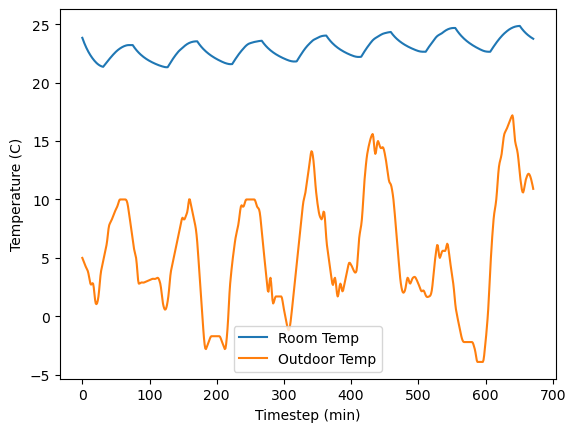

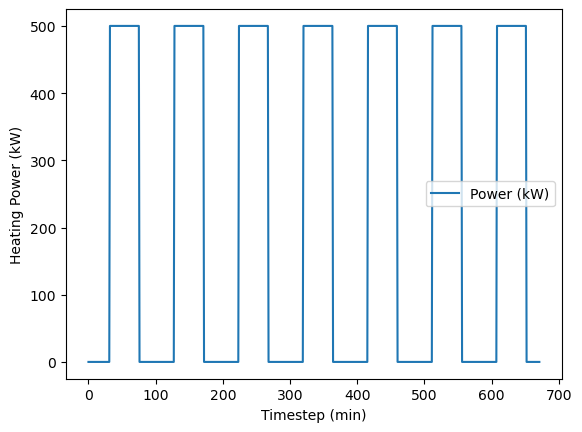

In [ ]:
bldg = Building(Ti,Te,Ri,Ro,Ci,Ce,Ai,Ae)
N = len(time)

Ti_history = np.zeros((N,1))   # Empty history of Ti
Te_history = np.zeros((N,1))   # Empty history of Te 
Phea_history = np.zeros((N,1)) # Empty history of Phea

for i in range(N):
  # Using Phea, To[i] and Isol[i] make the simulation go
  # forward by one step:
  bldg.nextStep(Phea[i],To[i],Isol[i])

  # Store the current values of Ti, Te and Phea before iterating:
  # get building indoor temperature
  Ti_history[i] = bldg.getTi() # Replace 0 with the proper method call
  # get building envelope temperature
  Te_history[i] = bldg.getTe() # Replace 0 with the proper method call
  Phea_history[i] = Phea[i] # We're using a scheduled power input 

# plot lines
plt.plot(Ti_history, label = "Room Temp")
plt.plot(To,label='Outdoor Temp')
plt.xlabel('Timestep (min)')
plt.ylabel('Temperature (C)')

plt.legend()
plt.show()
    
plt.plot(Phea_history, label = "Power (kW)")
plt.xlabel('Timestep (min)')
plt.ylabel('Heating Power (kW)')

plt.legend()
plt.show()